In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from timeit import default_timer as timer
from pathlib import Path
from tqdm.auto import tqdm
import requests




print(torch.__version__)
print(torchvision.__version__)

1.12.0
0.13.0


In [2]:
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skiping download')
else:
    print('download helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

helper_functions.py already exists, skiping download


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
train_data = datasets.MNIST(root='./data/MNIST',
                                  train=True,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=None
                                  )
test_data = datasets.MNIST(root='./data/MNIST',
                                  train=False,
                                  download=True,
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=None
                                  )

In [5]:
class_names = train_data.classes
image, label = train_data[0]
print(class_names)
print(image.shape, image.dtype)
print(image, label)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([1, 28, 28]) torch.float32
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.00

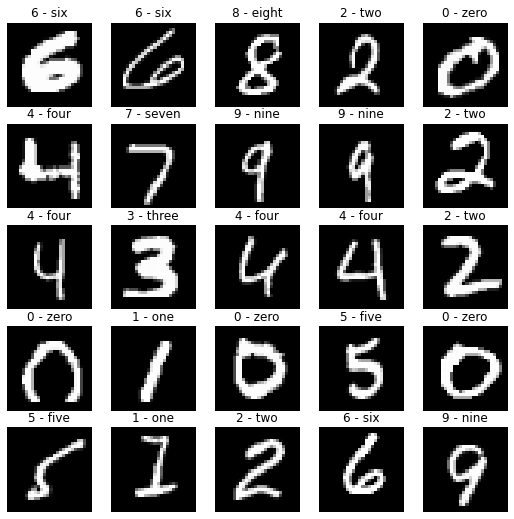

In [6]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols =5, 5
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label =train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [7]:
BATCH_SIZE=32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=0)

In [8]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            
            #make predictions
            y_pred = model(X)
            
            #accumulate the loss anda acc valuees per batch
            loss+= loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        #scale loss and acc to find the average loss/acc per batch
        loss = loss/len(data_loader)
        acc = acc/len(data_loader)
            
    return{'model_name': model.__class__.__name__,
           'model_loss': loss.item(),
           'model_acc': acc}

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    """ Performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    
    # put model into training mode
    model.train()
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # put data on target device
        X, y = X.to(device), y.to(device)
        
        #1 Forward pass (outputs the raw logits from the model)
        y_pred = model(X)
        
        # 2 Calcualte loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss #accumulate train loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # go from logits -> predictions labels
        
        #3 Optimizer zero grad
        optimizer.zero_grad()
        
        #4 loss backward
        loss.backward()
        
        #5 Optimizer step (update the model's parameters once per batch)
        optimizer.step()
            
     #divide total train loss and accuracy by length of train dataloader
    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)
    
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
    
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
             
    """Performs a testing loop step on model going over data_loader"""         
    
    test_loss, test_acc = 0, 0
    
    # put model into evaluation mode
    model.eval()
    
    # Turn on inference mode context manager
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            
            #Send data to the target device
            X_test, y_test = X_test.to(device), y_test.to(device)
              
            #1 Forward pass
            test_pred = model(X_test)
            #2 Calculate the loss
            test_loss += loss_fn(test_pred, y_test)
            # Calculate the accuracy
            test_acc += accuracy_fn(y_true=y_test, 
                                    y_pred=test_pred.argmax(dim=1)) # go from logits -> predictions labels
            
    #Calculate test loss 
    test_loss = test_loss / len(data_loader)
    
    #calculate test acc 
    test_acc = test_acc / len(data_loader)
    
    #print out what happenening
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

In [9]:
class MNISTModelv0(nn.Module):
    def __init__(self, input_shape:int,
                 hidden_units:int,
                 output_shape:int):


        super().__init__()
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=input_shape,
                                                      out_channels=hidden_units,
                                                      kernel_size=3,
                                                      stride=1,
                                                      padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=hidden_units,
                                                      out_channels=hidden_units,
                                                      kernel_size=3,
                                                      stride=1,
                                                      padding=1),
                                            nn.ReLU(),
                                            nn.MaxPool2d(kernel_size=2, stride=2)   
                                            )
        
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                      out_channels=hidden_units,
                                                      kernel_size=3,
                                                      stride=1,
                                                      padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=hidden_units,
                                                      out_channels=hidden_units,
                                                      kernel_size=3,
                                                      stride=1,
                                                      padding=1),
                                            nn.ReLU(),
                                            nn.MaxPool2d(kernel_size=2, stride=2)   
                                            )
        
        self.classifire = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features=hidden_units*7*7,
                                                  out_features=output_shape)
                                        )
        
        
        
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(f"output shape of convblock 1{x.shape}")
        x = self.conv_block_2(x)
        #print(f"output shape of convblock 2{x.shape}")
        x = self.classifire(x)
        #print(f"output shape of classifire {x.shape}")
        
        return x


In [10]:
torch.manual_seed(42)
model_1 = MNISTModelv0(input_shape = 1,
                             hidden_units = 10,
                             output_shape = len(class_names)).to(device)
model_1

MNISTModelv0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifire): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [11]:
def print_train_time(start: float,
                     end:float,
                     device: torch.device = None):
    """prints diffirence between start and end time"""
    total_time = end - start
    print(f"Train time on: {device}: {total_time:.3f} seconds")
    return total_time

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [12]:
train_time_start_on_gpu = timer()

epochs=5

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}\n--------")
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu,
                                            end = train_time_end_on_gpu,
                                            device=str(next(model_1.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0
--------
Train loss: 0.2659 | Train acc: 91.31%
Test loss: 0.0772, Test acc: 97.5739
epoch: 1
--------
Train loss: 0.0694 | Train acc: 97.86%
Test loss: 0.0428, Test acc: 98.5923
epoch: 2
--------
Train loss: 0.0541 | Train acc: 98.31%
Test loss: 0.0467, Test acc: 98.4724
epoch: 3
--------
Train loss: 0.0452 | Train acc: 98.59%
Test loss: 0.0434, Test acc: 98.5623
epoch: 4
--------
Train loss: 0.0400 | Train acc: 98.69%
Test loss: 0.0338, Test acc: 98.9018
Train time on: cuda:0: 99.286 seconds


In [13]:
#make predictions
y_preds = []
model_1.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        #send the data nad targets to target device
        X, y = X.to(device), y.to(device)
        #forward pass
        y_logit = model_1(X)
        #turn predictions from logits
        y_pred= torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        # put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1, 0, 4, 1, 8, 9, 8, 8])

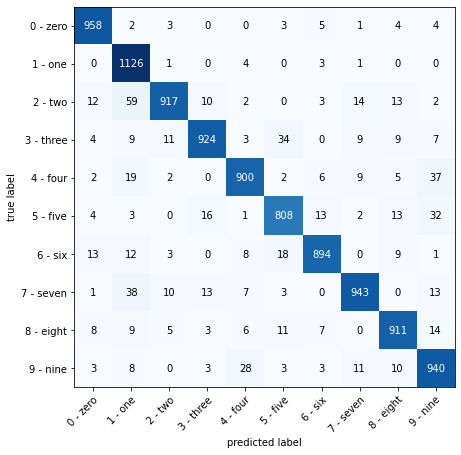

In [14]:
#setup confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                        target=test_data.targets)
confmat_tensor
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize=(10,7)
                               )